In [1]:
# !pip install nltk    
# !pip install emoji        
# !pip install autocorrec\t    
# !pip install xgboost
# !pip install -U spacy

In [2]:
# nltk.download('all-corpora')
# nltk.download('punkt')  # for using word_tokenizer
# nltk.download('wordnet')  # for using Lemmatizer
# nltk.download('averaged_perceptron_tagger') # for language processing i.e tagging words with their parts of speech (POS)
# !python -m spacy download en_core_web_lg

In [3]:
import pyspark.pandas as ps

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import spacy
import nltk
import re   # regular expression
import string
import multiprocessing
from multiprocessing import Pool
import scipy.sparse as sp
import joblib
import emoji
from autocorrect import Speller   # for correcting spelling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize    # for tokenizing string into words
from nltk.stem import WordNetLemmatizer    # for lemmatizing words
from nltk.tag import pos_tag # for tagging words with their parts of speech (POS)

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest,chi2, mutual_info_classif
from sklearn.decomposition import PCA

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import xgboost
# from xgboost import XGBClassifier

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

In [11]:
df_train = pd.read_csv('data/project_training_data_with_class_labels.csv',dtype=str,delimiter=',',quoting=3)

In [12]:
# df_train = ps.DataFrame(df_train)

In [13]:
df_train.shape

(808661, 4)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808661 entries, 0 to 808660
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               808661 non-null  object
 1   Comments         808623 non-null  object
 2   Parent Comments  808661 non-null  object
 3    Class Labels    808661 non-null  object
dtypes: object(4)
memory usage: 24.7+ MB


In [15]:
# to check for null value
df_train.isna().sum()

ID                  0
Comments           38
Parent Comments     0
 Class Labels       0
dtype: int64

In [16]:
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', ' Class Labels '], dtype='object')

In [17]:
df_train.rename(columns={' Class Labels ' : 'Class Labels'},inplace=True) # changing col name
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', 'Class Labels'], dtype='object')

In [18]:
# remove data points whose class labels are not present
# df_train.dropna(subset=['Comments'], inplace=True)      # then dropped that rows with no value

In [19]:
df_train= df_train.replace(to_replace = np.nan, value = '', regex = True)

In [20]:
# to check for null value
df_train.isna().sum()

ID                 0
Comments           0
Parent Comments    0
Class Labels       0
dtype: int64

In [21]:
# Inserting the column before Class Labels col.
df_train.insert(loc = 3,
        column = 'Text',
        value = df_train['Parent Comments'] + " " +df_train['Comments'])

df_train.head()

,ID,Comments,Parent Comments,Text,Class Labels
0,ocxtitan,Central Illinois,Jesus; where do you live?,Jesus; where do you live? Central Illinois,non-sarcastic
1,LeChuckly,To think - CNN used to be the acronym synonymo...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,non-sarcastic
2,throwitskrub8,But then again; you have to consider that all ...,agree to that part.It can also mean that gujra...,agree to that part.It can also mean that gujra...,non-sarcastic
3,fresherthanyouuu,ughhhhh,If a guy told you he doesn't use social media ...,If a guy told you he doesn't use social media ...,non-sarcastic
4,_kushagra,I should've put the,No; it's just a programming bug. After all; th...,No; it's just a programming bug. After all; th...,sarcastic


In [22]:
df_train.shape

(808661, 5)

In [23]:
# # we are combining Parent Comment and Comment cols. into one cols.
# df_train['Text'] = df_train['Parent Comments'] + " " +df_train['Comments']
# df_train.head()

In [24]:
# to check for null value
df_train.isnull().sum()

ID                 0
Comments           0
Parent Comments    0
Text               0
Class Labels       0
dtype: int64

In [25]:
# # we know that adding any thing with nan value gives nan. so in Text col having nan value we replace 
# # one time with comment col. value where value of parent comment col is nan and other with parent comment where
# # comment col. is empty.

# # fill the rows of Col. Text having no values with that of col. Parent Comments where Comment col. is empty
# df_train['Text'][df_train['Comments'].isnull()] = df_train['Parent Comments'][df_train['Comments'].isnull()]

# # fill the rows of Col. Text having no values with that of col. Comments where Parent Comment col. is empty
# df_train['Text'][df_train['Parent Comments'].isnull()] = df_train['Comments'][df_train['Parent Comments'].isnull()]

In [26]:
# # to check for null value
# df_train.isnull().sum()

Since here there is issue with the format of some rows. So we are manually correcting them.

In [27]:
df_test = pd.read_csv('data/project_test_data.csv',dtype=str,delimiter=',',quoting=3)
df_test.head()

,ID,Comments,Parent Comments
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.
2,Foxprowl,Poser.,Jon Stewart is going to HBO
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...


In [28]:
df_test.shape

(202166, 3)

In [29]:
# to check for null value
df_test.isnull().sum()

ID                   0
Comments            15
Parent Comments      0
dtype: int64

In [30]:
df_test= df_test.replace(to_replace = np.nan, value = '', regex = True)

In [31]:
# to check for null value
df_test.isnull().sum()

ID                  0
Comments            0
Parent Comments     0
dtype: int64

In [32]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments '], dtype='object')

In [33]:
df_test.rename(columns={'Parent Comments ': 'Parent Comments'},inplace = True)

In [34]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments'], dtype='object')

In [35]:
# we are combining Parent Comment and Comment cols. into one cols.
df_test['Text'] = df_test['Parent Comments'] + " " +df_test['Comments']
df_test.head()

,ID,Comments,Parent Comments,Text
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...,Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.,Likely due to creative and interesting content...
2,Foxprowl,Poser.,Jon Stewart is going to HBO,Jon Stewart is going to HBO Poser.
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...,Plus the Japanese typically do not talk shit w...


<AxesSubplot:>

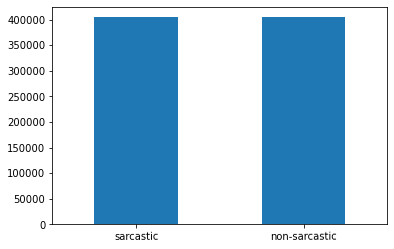

In [36]:
df_train['Class Labels'].value_counts().plot(kind = 'bar',rot = .3)

In [37]:
# english Stopwords
# stopwords_list = stopwords.words('english')

In [38]:
# # used this dictionary for expanding conracted words. this is taken from Github
# CONTRACTIONS = {
#     "I'm": "I am",
#     "I'm'a": "I am about to",
#     "I'm'o": "I am going to",
#     "I've": "I have",
#     "I'll": "I will",
#     "I'll've": "I will have",
#     "I'd": "I would",
#     "I'd've": "I would have",
#     "Whatcha": "What are you",
#     "amn't": "am not",
#     "ain't": "are not",
#     "aren't": "are not",
#     "'cause": "because",
#     "can't": "cannot",
#     "can't've": "cannot have",
#     "could've": "could have",
#     "couldn't": "could not",
#     "couldn't've": "could not have",
#     "daren't": "dare not",
#     "daresn't": "dare not",
#     "dasn't": "dare not",
#     "didn't": "did not",
#     "didn’t": "did not",
#     "don't": "do not",
#     "don’t": "do not",
#     "doesn't": "does not",
#     "e'er": "ever",
#     "everyone's": "everyone is",
#     "finna": "fixing to",
#     "gimme": "give me",
#     "gon't": "go not",
#     "gonna": "going to",
#     "gotta": "got to",
#     "hadn't": "had not",
#     "hadn't've": "had not have",
#     "hasn't": "has not",
#     "haven't": "have not",
#     "he've": "he have",
#     "he's": "he is",
#     "he'll": "he will",
#     "he'll've": "he will have",
#     "he'd": "he would",
#     "he'd've": "he would have",
#     "here's": "here is",
#     "how're": "how are",
#     "how'd": "how did",
#     "how'd'y": "how do you",
#     "how's": "how is",
#     "how'll": "how will",
#     "isn't": "is not",
#     "it's": "it is",
#     "'tis": "it is",
#     "'twas": "it was",
#     "it'll": "it will",
#     "it'll've": "it will have",
#     "it'd": "it would",
#     "it'd've": "it would have",
#     "kinda": "kind of",
#     "let's": "let us",
#     "luv": "love",
#     "ma'am": "madam",
#     "may've": "may have",
#     "mayn't": "may not",
#     "might've": "might have",
#     "mightn't": "might not",
#     "mightn't've": "might not have",
#     "must've": "must have",
#     "mustn't": "must not",
#     "mustn't've": "must not have",
#     "needn't": "need not",
#     "needn't've": "need not have",
#     "ne'er": "never",
#     "o'": "of",
#     "o'clock": "of the clock",
#     "ol'": "old",
#     "oughtn't": "ought not",
#     "oughtn't've": "ought not have",
#     "o'er": "over",
#     "shan't": "shall not",
#     "sha'n't": "shall not",
#     "shalln't": "shall not",
#     "shan't've": "shall not have",
#     "she's": "she is",
#     "she'll": "she will",
#     "she'd": "she would",
#     "she'd've": "she would have",
#     "should've": "should have",
#     "shouldn't": "should not",
#     "shouldn't've": "should not have",
#     "so've": "so have",
#     "so's": "so is",
#     "somebody's": "somebody is",
#     "someone's": "someone is",
#     "something's": "something is",
#     "sux": "sucks",
#     "that're": "that are",
#     "that's": "that is",
#     "that'll": "that will",
#     "that'd": "that would",
#     "that'd've": "that would have",
#     "em": "them",
#     "there're": "there are",
#     "there's": "there is",
#     "there'll": "there will",
#     "there'd": "there would",
#     "there'd've": "there would have",
#     "these're": "these are",
#     "they're": "they are",
#     "they've": "they have",
#     "they'll": "they will",
#     "they'll've": "they will have",
#     "they'd": "they would",
#     "they'd've": "they would have",
#     "this's": "this is",
#     "those're": "those are",
#     "to've": "to have",
#     "wanna": "want to",
#     "wasn't": "was not",
#     "we're": "we are",
#     "we've": "we have",
#     "we'll": "we will",
#     "we'll've": "we will have",
#     "we'd": "we would",
#     "we'd've": "we would have",
#     "weren't": "were not",
#     "what're": "what are",
#     "what'd": "what did",
#     "what've": "what have",
#     "what's": "what is",
#     "what'll": "what will",
#     "what'll've": "what will have",
#     "when've": "when have",
#     "when's": "when is",
#     "where're": "where are",
#     "where'd": "where did",
#     "where've": "where have",
#     "where's": "where is",
#     "which's": "which is",
#     "who're": "who are",
#     "who've": "who have",
#     "who's": "who is",
#     "who'll": "who will",
#     "who'll've": "who will have",
#     "who'd": "who would",
#     "who'd've": "who would have",
#     "why're": "why are",
#     "why'd": "why did",
#     "why've": "why have",
#     "why's": "why is",
#     "will've": "will have",
#     "won't": "will not",
#     "won't've": "will not have",
#     "would've": "would have",
#     "wouldn't": "would not",
#     "wouldn't've": "would not have",
#     "y'all": "you all",
#     "y'all're": "you all are",
#     "y'all've": "you all have",
#     "y'all'd": "you all would",
#     "y'all'd've": "you all would have",
#     "you're": "you are",
#     "you've": "you have",
#     "you'll've": "you shall have",
#     "you'll": "you will",
#     "you'd": "you would",
#     "you'd've": "you would have"
#  }
# with open('CONTRACTIONS.pkl', 'wb') as f:
#     pickle.dump(CONTRACTIONS, f)

In [39]:
# #I created a dictionary for emoticons
# EMOTICONS = {
#     u":‑)":"Happy",
#     u":-))":"Very Happy",
#     u":-)))":"Very very Happy",
#     u":)":"Happy",
#     u":))":"Very Happy",
#     u":)))":"Very very Happy",
#     u":-]":"Happy",
#     u":]":"Happy",
#     u":-3":"Happy",
#     u":3":"Happy",
#     u":->":"Happy",
#     u":>":"Happy",
#     u"8-)":"Happy",
#     u":o)":"Happy",
#     u":-}":"Happy",
#     u":}":"Happy",
#     u":-)":"Happy",
#     u":c)":"Happy",
#     u":^)":"Happy",
#     u"=]":"Happy",
#     u"=)":"Happy",
#     u":‑D":"Laughing",
#     u":D":"Laughing",
#     u"8‑D":"Laughing",
#     u"8D":"Laughing",
#     u"X‑D":"Laughing",
#     u"XD":"Laughing",
#     u"=D":"Laughing",
#     u"=3":"Laughing",
#     u"B^D":"Laughing",
#     u":-))":"Very happy",
#     u"<3":"love",
#     u":-(":"sad",
#     u":‑(":"sad",
#     u":(":"sad",
#     u":‑c":"sad",
#     u":c":"sad",
#     u":‑<":"sad",
#     u":<":"sad",
#     u":‑[":"sad",
#     u":[":"sad",
#     u":-||":"sad",
#     u">:[":"sad",
#     u":{":"sad",
#     u":@":"sad",
#     u">:(":"sad",
#     u":'‑(":"Crying",
#     u":'(":"Crying",
#     u":'‑)":"Tears of happiness",
#     u":')":"Tears of happiness",
#     u"D‑':":"sad",
#     u"D:<":"sad",
#     u"D:":"sad",
#     u"D8":"very sad",
#     u"D;":"very sad",
#     u"D=":"very sad",
#     u"DX":"very sad",
#     u":‑O":"Surprise",
#     u":O":"Surprise",
#     u":‑o":"Surprise",
#     u":o":"Surprise",
#     u":-0":"Sad",
#     u"8‑0":"Yawn",
#     u">:O":"Yawn",
#     u":-*":"Kiss",
#     u":*":"Kiss",
#     u":X":"Kiss",
#     u";‑)":"Wink",
#     u";)":"Wink",
#     u"*-)":"Wink",
#     u"*)":"Wink",
#     u";‑]":"Wink",
#     u";]":"Wink",
#     u";^)":"Wink",
#     u":‑,":"Wink",
#     u";D":"Wink",
#     u":‑P":"fun",
#     u":P":"fun",
#     u"X‑P":"fun",
#     u"XP":"fun",
#     u":‑Þ":"fun",
#     u":Þ":"fun",
#     u":b":"fun",
#     u"d:":"fun",
#     u"=p":"fun",
#     u">:P":"fun",
#     u":‑/":"annoyed",
#     u":/":"annoyed",
#     u":-[.]":"annoyed",
#     u">:[(\)]":"annoyed",
#     u">:/":"annoyed",
#     u":[(\)]":"annoyed",
#     u"=/":"annoyed",
#     u"=[(\)]":"annoyed",
#     u":L":"annoyed",
#     u"=L":"annoyed",
#     u":S":"annoyed",
#     u":‑|":"indecision",
#     u":|":"indecision",
#     u":$":"Embarrassed",
#     u":‑x":"Sealed lips or wearing braces or tongue-tied",
#     u":x":"Sealed lips or wearing braces or tongue-tied",
#     u":‑#":"Sealed lips or wearing braces or tongue-tied",
#     u":#":"Sealed lips or wearing braces or tongue-tied",
#     u":‑&":"Sealed lips or wearing braces or tongue-tied",
#     u":&":"Sealed lips or wearing braces or tongue-tied",
#     u"O:‑)":"Angel",
#     u"O:)":"Angel",
#     u"0:‑3":"Angel",
#     u"0:3":"Angel",
#     u"0:‑)":"Angel",
#     u"0:)":"Angel",
#     u":‑b":"fun",
#     u"0;^)":"Angel",
#     u">:‑)":"devilish",
#     u">:)":"devilish",
#     u"}:‑)":"devilish",
#     u"}:)":"devilish",
#     u"3:‑)":"devilish",
#     u"3:)":"devilish",
#     u">;)":"devilish",
#     u"|;‑)":"Cool",
#     u"|‑O":"Bored",
#     u":‑J":"Tongue in cheek",
#     u"#‑)":"Party all night",
#     u"%‑)":"confused",
#     u"%)":"confused",
#     u":-###..":"Being sick",
#     u":###..":"Being sick",
#     u"<:‑|":"silent",
#     u"(>_<)":"Troubled",
#     u"(>_<)>":"Troubled",
#     u"(';')":"Baby",
#     u"(^^>``":"Nervous",
#     u"(^_^;)":"Troubled",
#     u"(-_-;)":"Nervous",
#     u"(~_~;) (・.・;)":"Shy",
#     u"(-_-)zzz":"Sleeping",
#     u"(^_-)":"Wink",
#     u"((+_+))":"Confused",
#     u"(+o+)":"Confused",
#     u"(o|o)":"Ultraman",
#     u"^_^":"happy",
#     u"(^_^)/":"happy",
#     u"(^O^)／":"happy",
#     u"(^o^)／":"happy",
#     u"(__)":"Kowtow as a sign of respect, or dogeza for apology",
#     u"_(._.)_":"Kowtow as a sign of respect, or dogeza for apology",
#     u"<(_ _)>":"Kowtow as a sign of respect, or dogeza for apology",
#     u"<m(__)m>":"Kowtow as a sign of respect, or dogeza for apology",
#     u"m(__)m":"Kowtow as a sign of respect, or dogeza for apology",
#     u"m(_ _)m":"Kowtow as a sign of respect, or dogeza for apology",
#     u"('_')":"Sad",
#     u"(/_;)":"Sad",
#     u"(T_T) (;_;)":"Sad",
#     u"(;_;":"Sad",
#     u"(;_:)":"Sad",
#     u"(;O;)":"Sad",
#     u"(:_;)":"Sad",
#     u"(ToT)":"Sad",
#     u";_;":"Sad",
#     u";-;":"Sad",
#     u";n;":"Sad",
#     u";;":"Sad",
#     u"Q.Q":"Sad",
#     u"T.T":"Sad",
#     u"QQ":"Sad",
#     u"Q_Q":"Sad",
#     u"(-.-)":"Shame",
#     u"(-_-)":"Shame",
#     u"(一一)":"Shame",
#     u"(；一_一)":"Shame",
#     u"(=_=)":"Tired",
#     u"(=^·^=)":"cat",
#     u"(=^··^=)":"cat",
#     u"=_^= ":"cat",
#     u"(..)":"Looking down",
#     u"(._.)":"Looking down",
#     u"^m^":"Giggling",
#     u"(・・?":"Confusion",
#     u"(?_?)":"Confusion",
#     u">^_^<":"Normal Laugh",
#     u"<^!^>":"Normal Laugh",
#     u"^/^":"Normal Laugh",
#     u"（*^_^*）" :"Normal Laugh",
#     u"(^<^) (^.^)":"Normal Laugh",
#     u"(^^)":"Normal Laugh",
#     u"(^.^)":"Normal Laugh",
#     u"(^_^.)":"Normal Laugh",
#     u"(^_^)":"Normal Laugh",
#     u"(^^)":"Normal Laugh",
#     u"(^J^)":"Normal Laugh",
#     u"(*^.^*)":"Normal Laugh",
#     u"(^—^）":"Normal Laugh",
#     u"(#^.^#)":"Normal Laugh",
#     u"（^—^）":"Waving",
#     u"(;_;)/~~~":"Waving",
#     u"(^.^)/~~~":"Waving",
#     u"(-_-)/~~~ ($··)/~~~":"Waving",
#     u"(T_T)/~~~":"Waving",
#     u"(ToT)/~~~":"Waving",
#     u"(*^0^*)":"Excited",
#     u"(*_*)":"Excited",
#     u"(*_*;":"Excited",
#     u"(+_+) (@_@)":"Excited",
#     u"(*^^)v":"Cheerful",
#     u"(^_^)v":"Cheerful",
#     u"((d[-_-]b))":"Headphones,Listening to music",
#     u'(-"-)':"Worried",
#     u"(ーー;)":"Worried",
#     u"(^0_0^)":"Eyeglasses",
#     u"(＾ｖ＾)":"Happy",
#     u"(＾ｕ＾)":"Happy",
#     u"(^)o(^)":"Happy",
#     u"(^O^)":"Happy",
#     u"(^o^)":"Happy",
#     u")^o^(":"Happy",
#     u":O o_O":"Surprised",
#     u"o_0":"Surprised",
#     u"o.O":"Surpised",
#     u"(o.o)":"Surprised",
#     u"oO":"Surprised",
#     u"(*￣m￣)":"Dissatisfied",
#     u"(‘A`)":"Deflated"

# }
# with open('EMOTICONS.pkl', 'wb') as f:
#     pickle.dump(EMOTICONS, f)

In [40]:
    # english Stopwords
    stopwords_list = stopwords.words('english')
    with open('EMOTICONS.pkl', 'rb') as f1:
        EMOTICONS = pickle.load(f1)
    with open('CONTRACTIONS.pkl','rb') as f2:
        CONTRACTIONS = pickle.load(f2)

In [41]:
def preprocess_text(tweet):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pickle
    import time
    import spacy
    import nltk
    import re   # regular expression
    import string
    import multiprocessing
    from multiprocessing import Pool
    import scipy.sparse as sp
    import joblib
    import emoji
    from autocorrect import Speller   # for correcting spelling
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize    # for tokenizing string into words
    from nltk.stem import WordNetLemmatizer    # for lemmatizing words
    from nltk.tag import pos_tag # for tagging words with their parts of speech (POS)
    
    
    # english Stopwords
    stopwords_list = stopwords.words('english')
    with open('EMOTICONS.pkl', 'rb') as f1:
        EMOTICONS = pickle.load(f1)
    with open('CONTRACTIONS.pkl','rb') as f2:
        CONTRACTIONS = pickle.load(f2)
    
    nan_tweet = 'NaN'  
    # this code is to short unnecessary sentence, bec. some rows has unnecessary long repeated characters
    # like 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH'
    # we manually decide len = 10 any with len >10 is discarded
        # convert all text lowercase
    tweet = tweet.lower() 
    tweet = tweet.split()
    tw = []
    for t in tweet:
        # removing digits only
        if t.isnumeric():
            continue
        else:
            pass
        if len(t)<=20:
            if len(set(t))<=1:
                continue
            if sum(c.isdigit() for c in t) > sum(c.isalpha() for c in t):
                continue
            tw.append(t)
    tweet = ' '.join(tw)   
    # remove any urls
    tweet = re.sub(r"www\S+|http\S+|", "",tweet, flags = re.MULTILINE)
    # remove square bracket including its content if
    tweet = re.sub(r'\[|\]'," ",tweet)
    # to remove new line character
    tweet = re.sub(r'\n', " ", tweet)
    # remove user @ references and '#' from tweet
    tweet = re.sub(r"\@\w+|\#", "",tweet)
    # replace emojis with its meaning
    tweet = (emoji.demojize(tweet, delimiters=(" ", ""))).replace('_',' ')
    # expand contractions
    splitted_string = tweet.split()
    for index, text in enumerate(splitted_string):
        if text in CONTRACTIONS.keys():
            splitted_string[index] = CONTRACTIONS[text]
    tweet = ' '.join(splitted_string)
    # replace emoticons with its meaning
    splitted_tweet = tweet.split()
    for index, word in enumerate(splitted_tweet):
        if word in EMOTICONS.keys():
            splitted_tweet[index] = EMOTICONS[word]
    tweet = ' '.join(splitted_tweet)
    # remove tags
    tweet = re.sub(re.compile('<.*?>'), '', tweet)
    # remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    # remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stopwords_list]
    # spelling correction
    correct_words = []
    # initialize Speller object for english language
    spell_corrector = Speller(lang='en')
    for word in filtered_words:
        correct_word = spell_corrector(word)
        correct_words.append(correct_word)
    # lemmatizing
    wnl = WordNetLemmatizer()
    lemma_words = []
    for word, tag in pos_tag(correct_words):      # Part-of-speech constants for ADJ,VERB,ADV = 'a', 'r', 'v'
        if tag.startswith('JJ'):      # for adjectives
            lemma_word = wnl.lemmatize(word, pos='a')
            lemma_words.append(lemma_word)
        elif tag.startswith('VB'):   # for verbs
            lemma_word = wnl.lemmatize(word, pos='v')
            lemma_words.append(lemma_word)
        elif tag.startswith('RB'):   # for adverbs
            lemma_word = wnl.lemmatize(word, pos='r')
            lemma_words.append(lemma_word)
        else:
            lemma_word = word
            lemma_words.append(lemma_word)
        
    tweet = " ".join(lemma_words)
    if len(tweet) == 0:   # if after pre-processing sent. has no letter
        tweet = nan_tweet
    # f1.close(),f2.close()
    return tweet


In [42]:
# from pandas_parallel_apply import DataFrameParallel, apply_on_df_col_parallel, apply_on_series_parallel

In [43]:
# from multiprocesspandas import applyparallel

In [44]:
# df_train['Text'][0:100].apply_parallel(preprocess_text, num_processes=6)

In [45]:
# # DataFrameParallel(df_train, n_cores=4 , pbar=True)['Text'].apply(preprocess_text)
# r = apply_on_df_col_parallel(df_train[0:10], 'Text', preprocess_text, 4, pbar = True)

In [46]:
# 24000:250000 error somewhere
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [47]:
# num_cores = multiprocessing.cpu_count()
# num_partitions = num_cores-2 # leave some cores for other processes
# print(num_partitions)

# def parallelize_dataframe(df, func):
#     a = np.array_split(df, num_partitions)
#     del df
#     pool = Pool(num_cores)
#     df = sp.vstack(pool.map(func,a), format='csr')
#     pool.close()
#     pool.join()
#     return df

# # def test_func2(data,cv=CV,train=False):
# #     X_bow = cv.transform(data)
# #     return X_bow

In [48]:
# parallelize_dataframe(df_train['Text'][0:100],preprocess_text)

In [ ]:
t = time.time()
xx = df_train['Text'].parallel_apply(preprocess_text) 
df_train.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xx)
# saving
df_train.to_csv('processed_train.csv',index=False) # on train data, 
tt = time.time() - t
print(f'{tt} sec')

In [ ]:
t = time.time()
xtt = df_test['Text'].parallel_apply(preprocess_text) # on test data
df_test.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xtt)
df_test.to_csv('processed_test.csv',index=False)
tt = time.time() - t
print(f'{tt} sec')

In [ ]:
del df_train, df_test

### Reading the pre-processed csv

In [ ]:
df_prepro_train = pd.read_csv('processed_train.csv')

In [ ]:
print(df_prepro_train.shape)
df_prepro_train.head()

In [ ]:
df_prepro_train.isna().sum()

In [ ]:
# test
df_prepro_test = pd.read_csv('processed_test.csv')
print(df_prepro_test.shape)
df_prepro_test.head()

In [ ]:
df_prepro_test.isna().sum()

In [ ]:
# Train data
X = df_prepro_train['Pre Processed Text']
y_trn = df_prepro_train['Class Labels']

# Test data
X_test = df_prepro_test['Pre Processed Text']

In [ ]:
# converting Labels coloumn into numerical form of train data
encoder = LabelEncoder()
y = encoder.fit_transform(y_trn)

In [ ]:
encoder.classes_

In [ ]:
np.unique(y)

In [ ]:
# train validation split of data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=3,stratify=y)
X_train.shape,X_valid.shape

# BoW

In [ ]:
# cv = CountVectorizer(ngram_range=(1,3),max_features=60000) 
# X_train_bow = cv.fit_transform(X_train).toarray()
# X_valid_bow = cv.transform(X_valid).toarray()
# X_test_bow = cv.transform(X_test).toarray()

# X_train_bow.shape,X_valid_bow.shape,X_test_bow.shape

In [ ]:
CV = CountVectorizer(ngram_range=(1,3),max_features=100000) # (1,3) means Unigrams, Bigrams and Trigrams
X_train_bow = sp.csr_matrix(CV.fit_transform(X_train))  # compressing the data to use less memory 

In [ ]:
X_train_bow.shape

In [ ]:
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-2 # leave some cores for other processes
print(num_partitions)

def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    del df
    pool = Pool(num_cores)
    df = sp.vstack(pool.map(func,a), format='csr')
    pool.close()
    pool.join()
    return df

def test_func2(data,cv=CV,train=False):
    X_bow = cv.transform(data)
    return X_bow

In [ ]:
X_valid_bow = parallelize_dataframe(X_valid, test_func2)
X_valid_bow.shape

In [ ]:
X_test_bow = parallelize_dataframe(X_test, test_func2)
X_test_bow.shape

In [ ]:
joblib.dump(X_train_bow.tocsr(), 'X_train_bow.joblib')
joblib.dump(X_valid_bow.tocsr(), 'X_valid_bow.joblib')
joblib.dump(X_test_bow.tocsr(), 'X_test_bow.joblib')
del X_train_bow,X_valid_bow,X_test_bow # deleting the variable for freeing memory

# tf-idf

In [ ]:
# tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=60000,use_idf=True,smooth_idf=True)
# X_train_tfidf = tfidf.fit_transform(X_train).toarray()
# X_valid_tfidf = tfidf.transform(X_valid).toarray()
# X_test_tfidf = tfidf.transform(X_test).toarray()

# X_train_tfidf.shape,X_valid_tfidf.shape,X_test_tfidf.shape

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=100000,use_idf=True,smooth_idf=True)
X_train_tfidf = sp.csr_matrix(tfidf.fit_transform(X_train))

In [ ]:
X_train_tfidf.shape

In [ ]:
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-2 # leave some cores for other processes
print(num_partitions)

def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    del df
    pool = Pool(num_cores)
    df = sp.vstack(pool.map(func,a), format='csr')
    pool.close()
    pool.join()
    return df

def test_func2(data,cv=tfidf,train=False):
    X_bow = cv.transform(data)
    return X_bow

In [ ]:
X_valid_tfidf = parallelize_dataframe(X_valid, test_func2)
X_valid_tfidf.shape

In [ ]:
X_test_tfidf = parallelize_dataframe(X_test, test_func2)
X_test_tfidf.shape

In [ ]:
joblib.dump(X_train_tfidf.tocsr(), 'X_train_tfidf.joblib')
joblib.dump(X_valid_tfidf.tocsr(), 'X_valid_tfidf.joblib')
joblib.dump(X_test_tfidf.tocsr(), 'X_test_tfidf.joblib')
del X_train_tfidf,X_valid_tfidf,X_test_tfidf

# word embedding

### Word2Vec

In [ ]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
def word2vec_spacy(X):
    w2v_spacy = []
    for item in X.values: # .values returns dataframe rows as list, eg. 1st sentence as ['he is good']
        doc = nlp(item)
        w2v_spacy.append(doc.vector)
    w2v_spacy = np.array(w2v_spacy)
    return w2v_spacy

In [ ]:
# on train data
w2v_spacy_train = word2vec_spacy(X_train)

In [ ]:
w2v_spacy_train.shape

In [ ]:
w2v_spacy_train = sp.csr_matrix(w2v_spacy_train)

In [ ]:
# on validation data
w2v_spacy_valid = word2vec_spacy(X_valid)
w2v_spacy_valid.shape

In [ ]:
w2v_spacy_valid = sp.csr_matrix(w2v_spacy_valid)

In [ ]:
# on test data
w2v_spacy_test = word2vec_spacy(X_test)

In [ ]:
w2v_spacy_test.shape

In [ ]:
w2v_spacy_test = sp.csr_matrix(w2v_spacy_test)

In [ ]:
joblib.dump(w2v_spacy_train.tocsr(), 'w2v_spacy_train.joblib')
joblib.dump(w2v_spacy_valid.tocsr(), 'w2v_spacy_valid.joblib')
joblib.dump(w2v_spacy_test.tocsr(), 'w2v_spacy_test.joblib')
del w2v_spacy_train,w2v_spacy_valid,w2v_spacy_test

### Custom Training - W2V

In [27]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from gensim.models import Phrases

In [28]:
class MySentences(object):
    def __init__(self, sentences):
        self.sentences = sentences 
    def __iter__(self):
        for line in self.sentences:
            yield line.split()

In [29]:
sentences = MySentences(X_train)

In [30]:
# # Train a bigram detector.
# bigram_transformer = Phrases(sentences=sentences,connector_words=ENGLISH_CONNECTOR_WORDS)

# # Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
# model = Word2Vec(bigram_transformer[sentences],vector_size=300, min_count=1,workers=32)

In [31]:
# model.save('word2vec_b300.model')#bigram included w2v

In [37]:
w2v_b300 = Word2Vec.load('word2vec_b300.model')
w2v_b300.wv['good'].shape

(300,)

In [43]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec,dim):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec.keys()] or [np.zeros(self.dim)], axis=0) for words in X
        ])

In [44]:
w2v_b300_dict=dict(zip(w2v_b300.wv.index_to_key, w2v_b300.wv.vectors))

In [ ]:
etree_w2v_b300 = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_b300_dict,300)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200,n_jobs=32))])
Gau_w2v_b300 = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_b300_dict,300)),
    ("GaussianNB", GaussianNB())])
SVC_w2v_b300 = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_b300_dict,300)),
    ("SVC", SVC())])

In [ ]:
print('GaussianNB:',cross_val_score(Gau_w2v_b300,X_train,y_train,cv=5).mean())
print('etree:',cross_val_score(Gau_w2v_b300,X_train,y_train,cv=5).mean())
print('SVC:',cross_val_score(SVC_w2v_b300,X_train,y_train,cv=5).mean())

### Glove

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
glove_input_file = 'glove/glove.twitter.27B.200d.txt'
model_glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False,no_header=True)
# calculate: (king - man) + woman = ?
result = model_glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

In [ ]:
glove_dict=dict(zip(model.index_to_key, model.vectors))
etree_glove = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(glove_dict,200)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200,n_jobs=32))])
Gau_glove = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(glove_dict,200)),
    ("GaussianNB", GaussianNB())])

# Models

### With Feature Selection

In [16]:
from sklearn.linear_model import SGDClassifier

def logistic(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    fsl = 0
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training Logistic Regression Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline1 = Pipeline([('fs',fsl),
                          ('clf1', SGDClassifier(loss='log_loss',alpha=0.0001))])
    clf1_parameters = {
        'fs__k' : [500,5000,10000],
        'clf1__penalty':['l1', 'l2',],
        }
    grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=clf1_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search1.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search1.best_score_}")
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf1) 
    predicted_class_labels1 = clf1.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels1))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf1

In [17]:
def DecisionTree(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training Decision Tree Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline2 = Pipeline([('fs', fsl),
                          ('clf2', DecisionTreeClassifier(random_state=40))])
    clf2_parameters = {
        'fs__k' : [500,5000,10000],
        'clf2__criterion':['entropy','gini',], 
        'clf2__max_features':['sqrt', 'log2',None],
        'clf2__max_depth':[10,50,100,500],
        'clf2__ccp_alpha':[0.002,0.01,0.1,]
        }
    grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=clf2_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search2.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search2.best_score_}")
    clf2 = grid_search2.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf2)
    predicted_class_labels2 = clf2.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels2))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf2

In [18]:
def KNN(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training KNN Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline3 = Pipeline([('fs', fsl),
                          ('clf3', KNeighborsClassifier())])
    clf3_parameters = {
        'fs__k' : [500,3000,10000],
        'clf3__n_neighbors': [3,5,10,20,35],
        'clf3__weights':['uniform', 'distance',],
        'clf3__p':[1,2,],
        'clf3__metric':['euclidean', 'manhattan',] 
        }
    grid_search3 = GridSearchCV(estimator=pipeline3, param_grid=clf3_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search3.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search3.best_score_}")
    clf3 = grid_search3.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf3) 
    predicted_class_labels3 = clf3.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels3))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf3

In [19]:
def GaussianNBb(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    # Gaussian Naive Bayes
    print('\n\t ---------- Training Gaussian Naive Bayes Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline4 = Pipeline([('fs', fsl),
                          ('clf4', GaussianNB())])
    clf4_parameters = {
        'fs__k' : [500,3000,10000],
        'clf4__var_smoothing': np.logspace(0,-9, num=60)
        }
    grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=clf4_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search4.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search4.best_score_}")
    clf4 = grid_search4.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf4) 
    predicted_class_labels4 = clf4.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels4))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf4

In [48]:
def MultinomialNBb(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training Multinomial Naive Bayes Classifier ---------- \n')  
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline5 = Pipeline([('fs', fsl),
                          ('clf5', MultinomialNB(fit_prior=True, class_prior=None))])#('fs', fsl),
    clf5_parameters = {
        'fs__k' : [10000],#,3000,10000],
        'clf5__alpha':[20]
        }
    grid_search5 = GridSearchCV(estimator=pipeline5, param_grid=clf5_parameters, n_jobs=-1, cv=2, scoring='f1_macro',verbose=1)
    grid_search5.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search5.best_score_}")
    clf5 = grid_search5.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf5) 
    predicted_class_labels5 = clf5.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels5))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf5

In [21]:
def LinearSVCb(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training Linear SVC Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline8 = Pipeline([('fs', fsl),
                          ('clf8', LinearSVC(class_weight='balanced'))])
    clf8_parameters = {
        'fs__k' : [500,3000,10000],
        'clf8__C':[0.001,0.01,1,100,],
        }  
    grid_search8 = GridSearchCV(estimator=pipeline8, param_grid=clf8_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search8.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search8.best_score_}")
    clf8 = grid_search8.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf8) 
    predicted_class_labels8 = clf8.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels8))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf8

In [22]:
def SVCb(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training SVM Classifier ---------- \n') 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline9 = Pipeline([('fs', fsl),
                          ('clf9', SVC(probability=True))])
    clf9_parameters = {
        'fs__k' : [500,3000,10000],
        'clf9__C':[0.1,1,50,80,100,150],
        'clf9__kernel':['poly','linear','sigmoid',],
        }
    grid_search9 = GridSearchCV(estimator=pipeline9, param_grid=clf9_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search9.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search9.best_score_}")
    clf9 = grid_search9.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf9) 
    predicted_class_labels9 = clf9.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels9))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf9

In [23]:
def RandomForest(x_t,x_v,y_t, y_v,fs):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fs = fs
    
    if fs == 'MI' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
    
    print('\n\t ---------- Training Random Forest Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline10 = Pipeline([('fs', fsl),
                           ('clf10', RandomForestClassifier(class_weight='balanced'))])
    clf10_parameters = {
        'fs__k' : [500,3000,10000],
        'clf10__criterion':['entropy','gini',],
        'clf10__max_depth':[10,50,80,120],
        'clf10__n_estimators':[30,50,],
        'clf10__max_features':['sqrt','log2',None,] 
        } 
    grid_search10 = GridSearchCV(estimator=pipeline10, param_grid=clf10_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search10.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search10.best_score_}")
    clf10 = grid_search10.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf10) 
    predicted_class_labels10 = clf10.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels10))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf10

##### bow training

In [24]:
X_train_bow = joblib.load('X_train_bow.joblib', mmap_mode='c')
X_valid_bow = joblib.load('X_valid_bow.joblib', mmap_mode='c')

In [22]:
clf1bc = logistic(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')


	 ---------- Training Logistic Regression Classifier ---------- 



/home/nlp/khadga_19024/khadga_19024/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best score on Training set :  0.647427124607335


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x7fa19eaafa30>)),
                ('clf1', SGDClassifier(loss='log_loss'))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.63      0.71      0.67     80866
           1       0.67      0.59      0.63     80867

    accuracy                           0.65    161733
   macro avg       0.65      0.65      0.65    161733
weighted avg       0.65      0.65      0.65    161733

Process Completed and time taken is : 14.34 minutes


In [ ]:
clf1bm = logistic(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
clf2bc = DecisionTree(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf2bm = DecisionTree(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
clf3bc = KNN(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf3bm = KNN(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
clf4bc = GaussianNBb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf4bm = GaussianNBb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [40]:
clf5bc = MultinomialNBb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')


	 ---------- Training Multinomial Naive Bayes Classifier ---------- 

Fitting 2 folds for each of 150 candidates, totalling 300 fits
Best score on Training set :  0.6364028963396402


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x7ff18f10bb50>)),
                ('clf5', MultinomialNB(alpha=13))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     80866
           1       0.64      0.63      0.64     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

Process Completed and time taken is : 0.3 minutes


In [49]:
clf5bm = MultinomialNBb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')


	 ---------- Training Multinomial Naive Bayes Classifier ---------- 

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best score on Training set :  0.6352937636565796


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=10000,
                             score_func=<function mutual_info_classif at 0x7ff18f5427a0>)),
                ('clf5', MultinomialNB(alpha=20))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     80866
           1       0.65      0.61      0.63     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

Process Completed and time taken is : 160.78 minutes


In [ ]:
clf8bc = LinearSVCb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf8bm = LinearSVCb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
clf9bc = SVCb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf9bm = SVCb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
clf10bc = RandomForest(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf10bm = RandomForest(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [ ]:
del X_train_bow,X_valid_bow

In [ ]:
2+2

#### tf-idf

In [ ]:
X_train_tfidf = joblib.load('X_train_tfidf.joblib', mmap_mode='c')
X_valid_tfidf = joblib.load('X_valid_tfidf.joblib', mmap_mode='c')

In [ ]:
clf1tc = logistic(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf1tm = logistic(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf2tc = DecisionTree(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf2tm = DecisionTree(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf3tc = KNN(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf3tm = KNN(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf4tc = GaussianNBb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf4tm = GaussianNBb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf5tc = MultinomialNBb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf5tm = MultinomialNBb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf8tc = LinearSVCb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf8tm = LinearSVCb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf9tc = SVCb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf9tm = SVCb(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
clf10tc = RandomForest(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'chi2')

In [ ]:
clf10tm = RandomForest(X_train_tfidf,X_valid_tfidf, y_train, y_valid,'MI')

In [ ]:
del X_train_tfidf,X_valid_tfidf

#### word2vec

In [ ]:
def logisticw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Logistic Regression Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline1 = Pipeline([('clf1', LogisticRegression(class_weight='balanced'))])
    clf1_parameters = {
        'clf1__penalty':['l1', 'l2', 'elasticnet',],
        'clf1__C':[10,0.01,0.001,0.003],     
        'clf1__solver':['newton-cg','liblinear','sag',]
        }
    grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=clf1_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search1.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search1.best_score_}")
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf1) 
    predicted_class_labels1 = clf1.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels1))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf1

In [ ]:
def DecisionTreew2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Decision Tree Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline2 = Pipeline([('clf2', DecisionTreeClassifier(random_state=40))])
    clf2_parameters = {
        'clf2__criterion':['entropy','gini',], 
        'clf2__max_features':['sqrt', 'log2',None],
        'clf2__max_depth':[10,25,40,100],
        'clf2__ccp_alpha':[0.002,0.01,0.1,]
        }
    grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=clf2_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search2.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search2.best_score_}")
    clf2 = grid_search2.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf2)
    predicted_class_labels2 = clf2.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels2))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf2

In [ ]:
def KNNw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training KNN Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline3 = Pipeline([('clf3', KNeighborsClassifier())])
    clf3_parameters = {
        'clf3__n_neighbors': [5,10,20,35,],      
        'clf3__weights':['uniform', 'distance',],
        'clf3__p':[1,2,],
        'clf3__metric':['euclidean', 'manhattan',] 
        }
    grid_search3 = GridSearchCV(estimator=pipeline3, param_grid=clf3_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search3.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search3.best_score_}")
    clf3 = grid_search3.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf3) 
    predicted_class_labels3 = clf3.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels3))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf3

In [ ]:
def GaussianNBw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    # Gaussian Naive Bayes
    print('\n\t ---------- Training Gaussian Naive Bayes Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline4 = Pipeline([('clf4', GaussianNB())])
    clf4_parameters = {
        'clf4__var_smoothing': np.logspace(0,-9, num=60)
        }
    grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=clf4_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search4.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search4.best_score_}")
    clf4 = grid_search4.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf4) 
    predicted_class_labels4 = clf4.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels4))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf4

In [ ]:
def MultinomialNBw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Multinomial Naive Bayes Classifier ---------- \n')  
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline5 = Pipeline([('clf5', MultinomialNB(fit_prior=True, class_prior=None))])
    clf5_parameters = {
        'clf5__alpha':[0,1,]
        }
    grid_search5 = GridSearchCV(estimator=pipeline5, param_grid=clf5_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search5.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search5.best_score_}")
    clf5 = grid_search5.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf5) 
    predicted_class_labels5 = clf5.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels5))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf5

In [ ]:
def LinearSVCw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Linear SVC Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline8 = Pipeline([('clf8', LinearSVC(class_weight='balanced'))])
    clf8_parameters = {
        'clf8__C':[0.001,0.01,1,100,],
        }  
    grid_search8 = GridSearchCV(estimator=pipeline8, param_grid=clf8_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search8.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search8.best_score_}")
    clf8 = grid_search8.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf8) 
    predicted_class_labels8 = clf8.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels8))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf8

In [ ]:
def SVCw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training SVM Classifier ---------- \n') 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline9 = Pipeline([('clf9', SVC(probability=True))])
    clf9_parameters = {
        'clf9__C':[0.1,1,50,80,100,150],
        'clf9__kernel':['poly','linear','sigmoid',],
        }
    grid_search9 = GridSearchCV(estimator=pipeline9, param_grid=clf9_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search9.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search9.best_score_}")
    clf9 = grid_search9.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf9) 
    predicted_class_labels9 = clf9.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels9))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf9

In [ ]:
def RandomForestw2v(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Random Forest Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline10 = Pipeline([('clf10', RandomForestClassifier(class_weight='balanced'))])
    clf10_parameters = {
        'clf10__criterion':['entropy','gini',],
        'clf10__max_depth':[10,30,80,120,],
        'clf10__n_estimators':[30,50,],
        'clf10__max_features':['sqrt','log2',None,] 
        } 
    grid_search10 = GridSearchCV(estimator=pipeline10, param_grid=clf10_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search10.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search10.best_score_}")
    clf10 = grid_search10.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf10) 
    predicted_class_labels10 = clf10.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels10))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf10

##### spacy

In [ ]:
w2v_spacy_train = joblib.load('w2v_spacy_train.joblib', mmap_mode='c')
w2v_spacy_valid = joblib.load('w2v_spacy_valid.joblib', mmap_mode='c')

In [ ]:
clf1w = logisticw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf2w = DecisionTreew2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf3w = KNNw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf4w = GaussianNBw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf5w = MultinomialNBw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf8w = LinearSVCw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf9w = SVCw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
clf10w = RandomForestw2v(w2v_spacy_train,w2v_spacy_valid, y_train, y_valid)

In [ ]:
del w2v_spacy_train,w2v_spacy_valid

##### Glove

In [ ]:
glove_spacy_train,glove_spacy_valid

In [ ]:
clf1g = logisticw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf2g = DecisionTreew2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf3g = KNNw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf4g = GaussianNBw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf5g = MultinomialNBw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf8g = LinearSVCw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf9g = SVCw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

In [ ]:
clf10g = RandomForestw2v(glove_spacy_train,glove_spacy_valid, y_train, y_valid)

### with PCA

In [ ]:
def logisticpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Logistic Regression Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline1 = Pipeline([('fs',PCA(n_components = 0.98)),
                          ('clf1', LogisticRegression(class_weight='balanced'))])
    clf1_parameters = {
        'clf1__penalty':[l1', 'l2', 'elasticnet',],
        'clf1__C':[10,0.01,0.001,0.003,],
        'clf1__solver':['newton-cg','liblinear','sag',]
        }
    grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=clf1_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search1.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search1.best_score_}")
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf1) 
    predicted_class_labels1 = clf1.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels1))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf1

In [ ]:
def DecisionTreepca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Decision Tree Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline2 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf2', DecisionTreeClassifier(random_state=40))])
    clf2_parameters = {
        'clf2__criterion':['entropy','gini',], 
        'clf2__max_features':['sqrt', 'log2',None],
        'clf2__max_depth':[10,25,40,100],
        'clf2__ccp_alpha':[0.002,0.01,0.1,]
        }
    grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=clf2_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search2.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search2.best_score_}")
    clf2 = grid_search2.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf2)
    predicted_class_labels2 = clf2.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels2))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf2

In [ ]:
def KNNpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training KNN Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline3 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf3', KNeighborsClassifier())])
    clf3_parameters = {
        'clf3__n_neighbors': [3,10,20,35,],      
        'clf3__weights':['uniform', 'distance',],
        'clf3__p':[1,2,],
        'clf3__metric':['euclidean', 'manhattan',] 
        }
    grid_search3 = GridSearchCV(estimator=pipeline3, param_grid=clf3_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search3.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search3.best_score_}")
    clf3 = grid_search3.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf3) 
    predicted_class_labels3 = clf3.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels3))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf3

In [ ]:
def GaussianNBpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    # Gaussian Naive Bayes
    print('\n\t ---------- Training Gaussian Naive Bayes Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline4 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf4', GaussianNB())])
    clf4_parameters = {
        'clf4__var_smoothing': np.logspace(0,-9, num=60)
        }
    grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=clf4_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search4.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search4.best_score_}")
    clf4 = grid_search4.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf4) 
    predicted_class_labels4 = clf4.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels4))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf4

In [ ]:
def MultinomialNBpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Multinomial Naive Bayes Classifier ---------- \n')  
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline5 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf5', MultinomialNB(fit_prior=True, class_prior=None))])
    clf5_parameters = {
        'clf5__alpha':[0,1,]
        }
    grid_search5 = GridSearchCV(estimator=pipeline5, param_grid=clf5_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search5.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search5.best_score_}")
    clf5 = grid_search5.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf5) 
    predicted_class_labels5 = clf5.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels5))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf5

In [ ]:
def LinearSVCpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Linear SVC Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline8 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf8', LinearSVC(class_weight='balanced'))])
    clf8_parameters = {
        'clf8__C':[0.001,0.01,1,100,],
        }  
    grid_search8 = GridSearchCV(estimator=pipeline8, param_grid=clf8_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search8.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search8.best_score_}")
    clf8 = grid_search8.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf8) 
    predicted_class_labels8 = clf8.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels8))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf8

In [ ]:
def SVCpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training SVM Classifier ---------- \n') 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline9 = Pipeline([('fs', PCA(n_components = 0.98)),
                          ('clf9', SVC(probability=True))])
    clf9_parameters = {
        'clf9__C':[0.1,1,50,80,100,150],
        'clf9__kernel':['poly','linear','sigmoid',],
        }
    grid_search9 = GridSearchCV(estimator=pipeline9, param_grid=clf9_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search9.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search9.best_score_}")
    clf9 = grid_search9.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf9) 
    predicted_class_labels9 = clf9.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels9))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf9

In [ ]:
def RandomForestpca(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    print('\n\t ---------- Training Random Forest Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    pipeline10 = Pipeline([('fs', PCA(n_components = 0.98)),
                           ('clf10', RandomForestClassifier(class_weight='balanced'))])
    clf10_parameters = {
        'clf10__criterion':['entropy','gini',],
        'clf10__max_depth':[10,30,80,120,],
        'clf10__n_estimators':[30,50,100,],
        'clf10__max_features':['sqrt','log2',None,] 
        } 
    grid_search10 = GridSearchCV(estimator=pipeline10, param_grid=clf10_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search10.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search10.best_score_}")
    clf10 = grid_search10.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf10) 
    predicted_class_labels10 = clf10.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels10))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf10

In [ ]:
clf1pca = logisticpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf2pca = DecisionTreepca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf3pca = KNNpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf4pca = GaussianNBpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf5pca = MultinomialNBpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf8pca = LinearSVCpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf9pca = SVCpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
clf10pca = RandomForestpca(X_train_bow, X_valid_bow, y_train, y_valid)

In [ ]:
# Evaluation
print('\n Total documents in the training set: '+str(len(trn_data))+'\n')    
print('\n Total documents in the test set: '+str(len(tst_data))+'\n') 

pr=precision_score(tst_cat, predicted, average='binary') 
print ('\n Precision:'+str(pr)) 

rl=recall_score(tst_cat, predicted, average='binary') 
print ('\n Recall:'+str(rl))

In [ ]:
clf1_mis = logistic_fs(x_trains,x_valids,y_train, y_valid,'MI') # by standardisation

In [ ]:
clf1_anovas = logistic_fs(x_trains,x_valids,y_train, y_valid,'ANOVA') # Standardisation

In [ ]:
# to get name of the 5 best features in decresing order i.e 1st feature is high import. then 2nd fet then 3rd so on
X_train.columns[sel_five_cols.get_support()] # x_train is the same as my x_train

In [ ]:
# best model

In [ ]:
ffl = logistic_fsf(x_trains,x_valids,y_train,y_valid)

In [ ]:
predl = ffl.predict(x_tests)

In [ ]:
# saving predicted class labels as txt file
np.savetxt('Akash_Singh_test_class_labels.txt',predl,fmt='%d',delimiter='\n')

In [1]:
2+2

4